### Numerical Computational Geometry

This field arose simultaneously among different groups of researchers seeking solutions to a priori non-related problems.  As it turns out, all the solutions they posed did actually have an important common denominator: they were obtained upon representing objects by means of parametric curves, parametric surfaces, or regions bounded by those.   These scientists ended up unifying their techniques over the years, to finally define the field of Numerical Computational Geometry.  In this journey, the field received different names: *Machine Geometry*, *Geometric Modeling*, and the most widespread *Computer Aided Geometric Design* (*CAGD*).

It is used in computer vision, for example, for 3D reconstruction and movement outline.   It is widely employed for the design and qualitative analysis of  the bodies of automobiles, aircraft, or watercraft.  There are many computer aided design software packages (*CAD*) that facilitate interactive manipulation and solution of many of the problems in this area.  In this regard, any interaction with `python` gets relegated to being part of the underlying computational engine behind the visualization or animation --- which are none of the strengths of `scipy`.  For this reason, we will not cover visualization or animation applications in this book, and focus on the basic mathematics instead.

In that regard, the foundation of Numerical Computational Geometry is based on three key concepts: Bézier surfaces, Coons patches, and B-spline methods.   In turn, the theory of Bézier curves plays a central role in the development of these concepts.  They are the geometric standard for the representation of piecewise polynomial curves.  In this section we focus solely on the basic development of the theory of plane Bézier curves.

> The rest of the material is also beyond the scope of `scipy`, and we therefore leave its exposition to more technical books.  The best source in that sense is, without a doubt, the book _Curves and Surfaces for Computer Aided Geometric Design---A Practical Guide_ (5th ed.), by Gerald Farin, published by Academic Press under the Morgan Kauffman Series in Computer Graphics and Geometric Modeling. 

#### Bézier Curves

It all starts with the *de Casteljau Algorithm* to construct parametric equations of an arc of a polynomial of order 3.  In the submodule `matplotlib.path`  we have an implementation of this algorithm using the class `Path`, which we can use to generate our own user-defined routines to generate and plot plane Bézier curves.

> For information about the class `Path` and its usage within the `matplotlib` libraries, refer to the official documentation at matplotlib.org/api/path_api.html#matplotlib.path.Path, as well as the very instructive tutorial at matplotlib.org/users/path_tutorial.html.  In this section, we focus solely on the necessary material to deal with Bézier curves.


In [1]:
import numpy as np, matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path

%matplotlib inline

def bezier_parabola(P1, P2, P3):
   return Path([P1, P2, P3],
               [Path.MOVETO, Path.CURVE3, Path.CURVE3])

def bezier_cubic(P1, P2, P3, P4):
    return Path([P1, P2, P3, P4],
                [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4])

def plot_path(path, labels=None):
    Xs, Ys = zip(*path.vertices)
    fig = plt.figure(figsize=(12,6))
    ax  = fig.add_subplot(111, aspect='equal')
    ax.set_xlim(min(Xs)-0.2, max(Xs)+0.2)
    ax.set_ylim(min(Ys)-0.2, max(Ys)+0.2)
    patch = patches.PathPatch(path, facecolor='none', linewidth=2)
    ax.add_patch(patch)
    ax.plot(Xs, Ys, 'o--', color='blue', linewidth=1)
    if labels:
        for k in range(len(labels)):
            ax.text(path.vertices[k][0]-0.1, path.vertices[k][1]-0.1, labels[k])
    plt.show()

Before we proceed, we need some explanation of the previous code.

* The de Casteljau algorithm for arcs of polynomials of order 2 is performed by creating a `Path` with the three control points as vertices, and the list `[Path.MOVETO, Path.CURVE3, Path.CURVE3]` as code.  This ensures that the resulting curve starts at `P1` in the direction given by the segment `P1P2`, and ends at `P3` with direction given by the segment `P2P3`.  If the three points are collinear, we obtain a segment containing them all.  Otherwise, we obtain an arc of parabola.

* The de Casteljau algorithm for arcs of polynomials of order 3 is performed in a similar way to the previous case.  We have four control points, and we create a `Path` with those as vertices.  The code is the list `[Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4]`, which ensures that the arc starts at `P1` with direction given by the segment `P1P2`.  It also ensures that the arc ends at `P4` in the direction of the segment `P3P4`.  

Let us test it with a few basic examples:

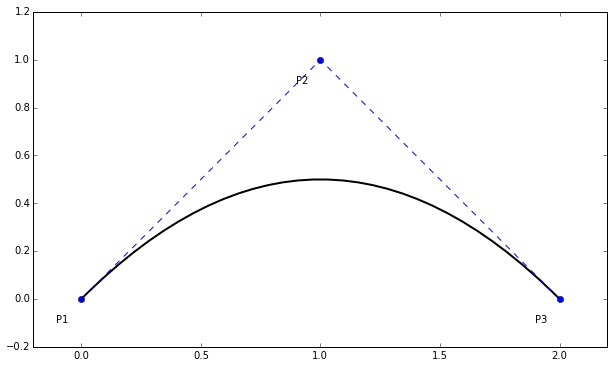

In [2]:
P1 = (0.0, 0.0)
P2 = (1.0, 1.0)
P3 = (2.0, 0.0)
path_1 = bezier_parabola(P1, P2, P3)
plot_path(path_1, labels=['P1', 'P2', 'P3'])

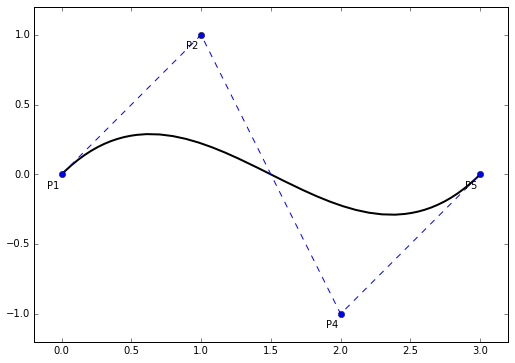

In [3]:
P4 = (2.0, -1.0)
P5 = (3.0, 0.0)
path_2 = bezier_cubic(P1, P2, P4, P5)
plot_path(path_2, labels=['P1', 'P2', 'P4', 'P5'])

Higher degree curves are computationally expensive to evaluate.  When complex paths are needed, we rather create them as a piecewise sequence of low order Bézier patched together---we call this object a *Bézier spline*.   Notice it is not hard to guarantee continuity on these splines.  It is enough to make the end of each path the starting point of the next one.  It is also easy to guarantee smoothness (at least up to the first derivative), by making the last two control points of one curve be aligned with the first two control points of the next one.  Let us illustrate this with an example.

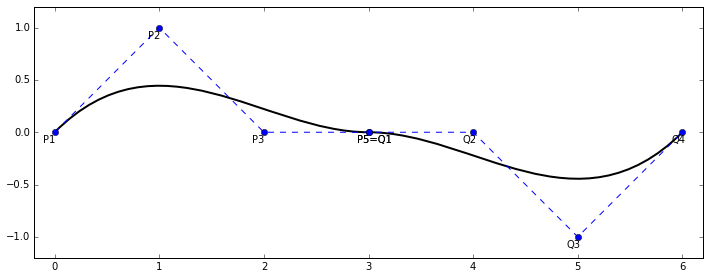

In [4]:
Q1 = P5
Q2 = (4.0, 0.0)
Q3 = (5.0, -1.0)
Q4 = (6.0, 0.0)
path_3 = bezier_cubic(P1, P2, P3, P5)
path_4 = bezier_cubic(Q1, Q2, Q3, Q4)
plot_path(Path.make_compound_path(path_3, path_4), labels=['P1', 'P2', 'P3', 'P5=Q1', 'P5=Q1', 'Q2', 'Q3', 'Q4'])

A clear advantage of representing curves as Bézier splines arises when we need to apply an affine transformation to a curve.  For instance, if we required a counter-clockwise rotated version of the last curve computed, instead of performing the operation over all points of the curve, we simply apply the transformation to the control points, and repeat the de Casteljau algorithm on the new controls.


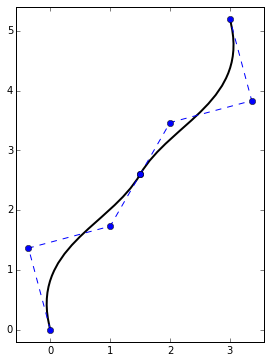

In [5]:
def rotation(point, angle):
    return (np.cos(angle)*point[0] - np.sin(angle)*point[1], 
            np.sin(angle)*point[0] + np.cos(angle)*point[1])

new_Ps = [rotation(P, np.pi/3) for P in path_3.vertices]
new_Qs = [rotation(Q, np.pi/3) for Q in path_4.vertices]
path_5 = bezier_cubic(*new_Ps)
path_6 = bezier_cubic(*new_Qs)
plot_path(Path.make_compound_path(path_5, path_6))